In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [2]:
df = pd.read_csv("sky_features.csv")

features = ['cloud_coverage', 'white_pixel_ratio', 'sun_luminance_mean',
            'sun_luminance_max', 'hour', 'minute']

# –Ø–∫—â–æ –ø–æ—Ç—Ä—ñ–±–Ω–æ –ø—ñ–¥–≥–æ—Ç–æ–≤–∏—Ç–∏ –æ–∑–Ω–∞–∫–∏
X = df[features]
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [3]:
def detect_sun_and_light_percent(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, int(0.98 * np.max(gray)), 255, cv2.THRESH_BINARY)

    # –ó–Ω–∞—Ö–æ–¥–∏–º–æ –∫–æ–Ω—Ç—É—Ä–∏ —è—Å–∫—Ä–∞–≤–∏—Ö –∑–æ–Ω
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return (0, 0), 0.0  # fallback

    # –í–∏–±–∏—Ä–∞—î–º–æ –Ω–∞–π–±—ñ–ª—å—à—É —è—Å–∫—Ä–∞–≤—É –∑–æ–Ω—É (–º–æ–∂–ª–∏–≤–æ —Å–æ–Ω—Ü–µ)
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)

    if M["m00"] == 0:
        return (0, 0), 0.0

    # –¶–µ–Ω—Ç—Ä –º–∞—Å–∏ –∫–æ–Ω—Ç—É—Ä—É ‚Äî –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∏ —Å–æ–Ω—Ü—è
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # –û—Å–≤—ñ—Ç–ª–µ–Ω—ñ—Å—Ç—å ‚Äî —Å–µ—Ä–µ–¥–Ω—î –∑–Ω–∞—á–µ–Ω–Ω—è –≤—Å—ñ—Ö –ø—ñ–∫—Å–µ–ª—ñ–≤ –≤ –∫–æ–Ω—Ç—É—Ä—ñ
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    light_pixels = gray[mask == 255]
    light_level = np.mean(light_pixels) / 255 * 100

    return (cx, cy), light_level



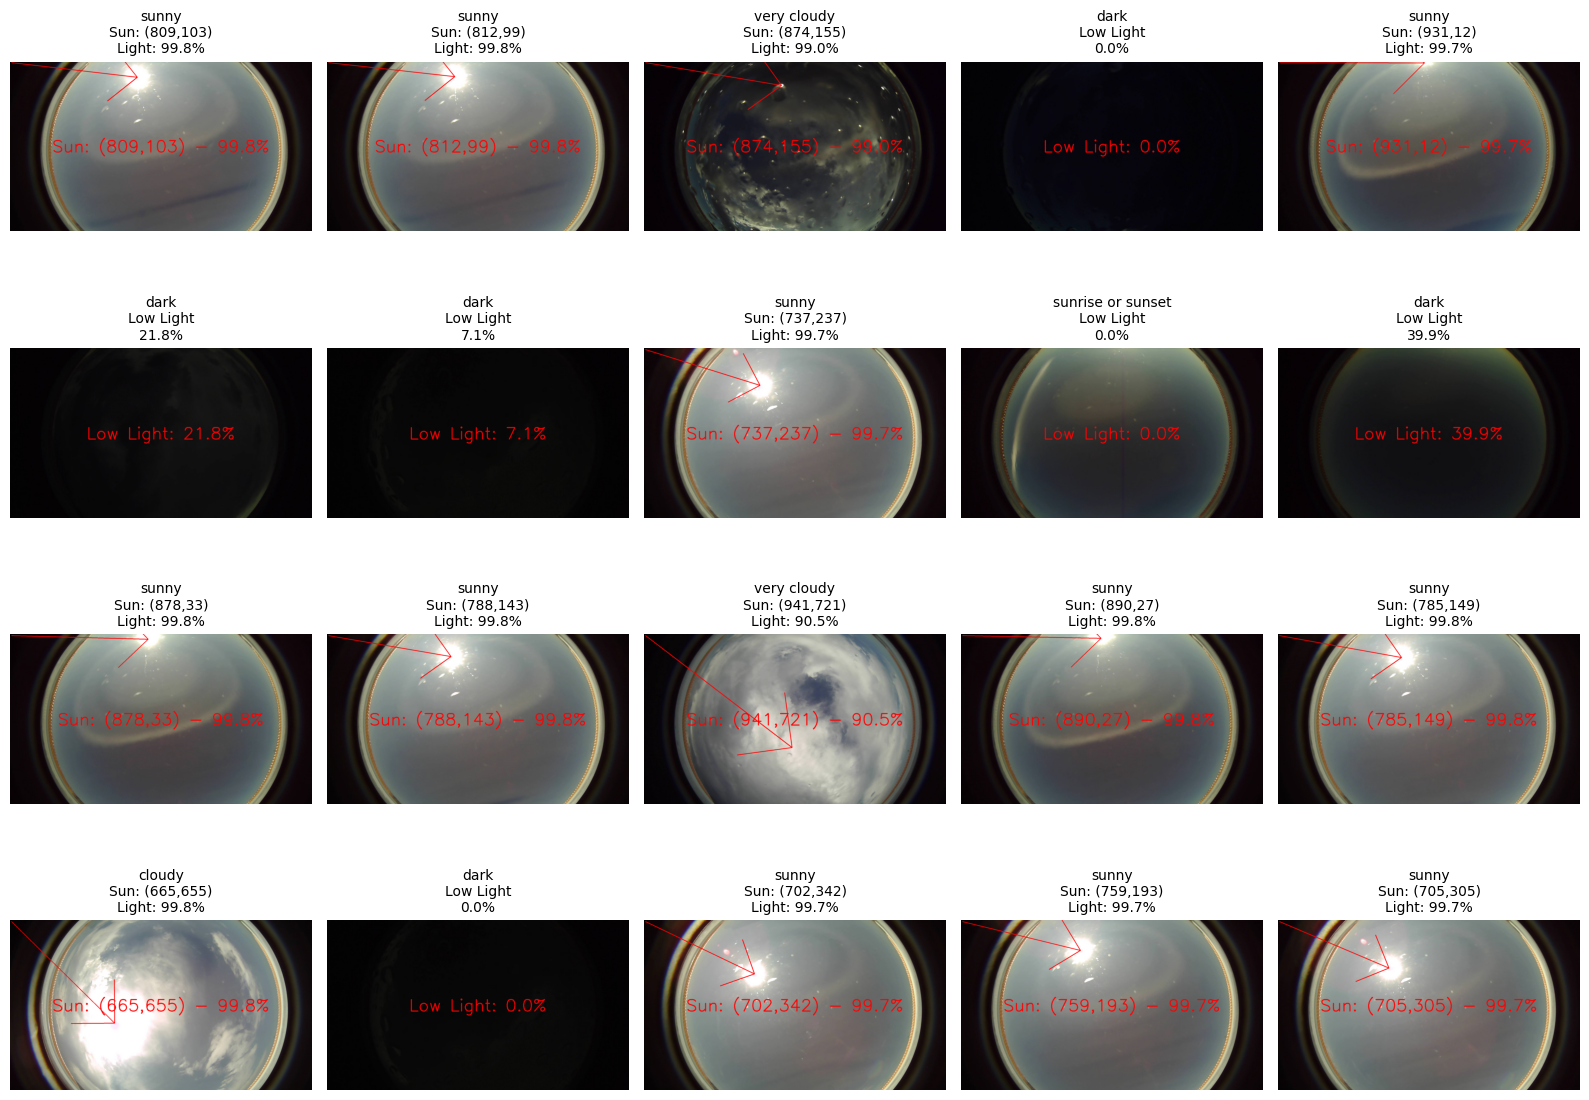

In [ ]:
sample = df.sample(20, random_state=42)

plt.figure(figsize=(16, 12))

for i, row in enumerate(sample.itertuples()):
    path = os.path.join("images", row.label, os.path.basename(row.filename))
    img = cv2.imread(path)

    if img is None:
        print(f"‚ö†Ô∏è –ü—Ä–æ–ø—É—â–µ–Ω–æ: {path}")
        continue

    sun_pos, light_pct = detect_sun_and_light_percent(img)
    h, w = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 3.5  # üëà –∑–º—ñ–Ω—é–π —Ä–æ–∑–º—ñ—Ä —à—Ä–∏—Ñ—Ç—É —Ç—É—Ç
    thickness = 5     # üëà —ñ —Ç–æ–≤—â–∏–Ω—É —Ç–µ–∫—Å—Ç—É

    if light_pct >= 70:
        x, y = sun_pos
        cv2.arrowedLine(img, (10, 10), (x, y), (0, 0, 255), 3, tipLength=0.3)

        text = f"Sun: ({x},{y}) - {light_pct:.1f}%"
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
        x_text = (w - tw) // 2
        y_text = (h + th) // 2

        cv2.putText(
            img,
            text,
            (x_text, y_text),
            font,
            font_scale,
            (0, 0, 255),
            thickness
        )

        title_text = f"{row.label}\nSun: ({x},{y})\nLight: {light_pct:.1f}%"
    else:
        text = f"Low Light: {light_pct:.1f}%"
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
        x_text = (w - tw) // 2
        y_text = (h + th) // 2

        cv2.putText(
            img,
            text,
            (x_text, y_text),
            font,
            font_scale,
            (0, 0, 255),
            thickness
        )

        title_text = f"{row.label}\nLow Light\n{light_pct:.1f}%"

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(title_text, fontsize=10)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# –°—Ç–≤–æ—Ä–µ–Ω–Ω—è —Ç–∞–±–ª–∏—Ü—ñ –∞—Ä—Ö—ñ—Ç–µ–∫—Ç—É—Ä–∏ –º–æ–¥–µ–ª—ñ
model_summary = []

for i, layer in enumerate(model.layers):
    layer_type = layer.__class__.__name__
    output_shape = str(layer.output_shape)
    params = layer.count_params()
    activation = getattr(layer, 'activation', None)
    activation_name = activation.__name__ if activation else '-'

    model_summary.append({
        "‚Ññ": i + 1,
        "–¢–∏–ø —à–∞—Ä—É": layer_type,
        "–†–æ–∑–º—ñ—Ä –≤–∏—Ö–æ–¥—É": output_shape,
        "–ö—ñ–ª—å–∫—ñ—Å—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤": params,
        "–§—É–Ω–∫—Ü—ñ—è –∞–∫—Ç–∏–≤–∞—Ü—ñ—ó": activation_name
    })

model_df = pd.DataFrame(model_summary)


NameError: name 'model' is not defined

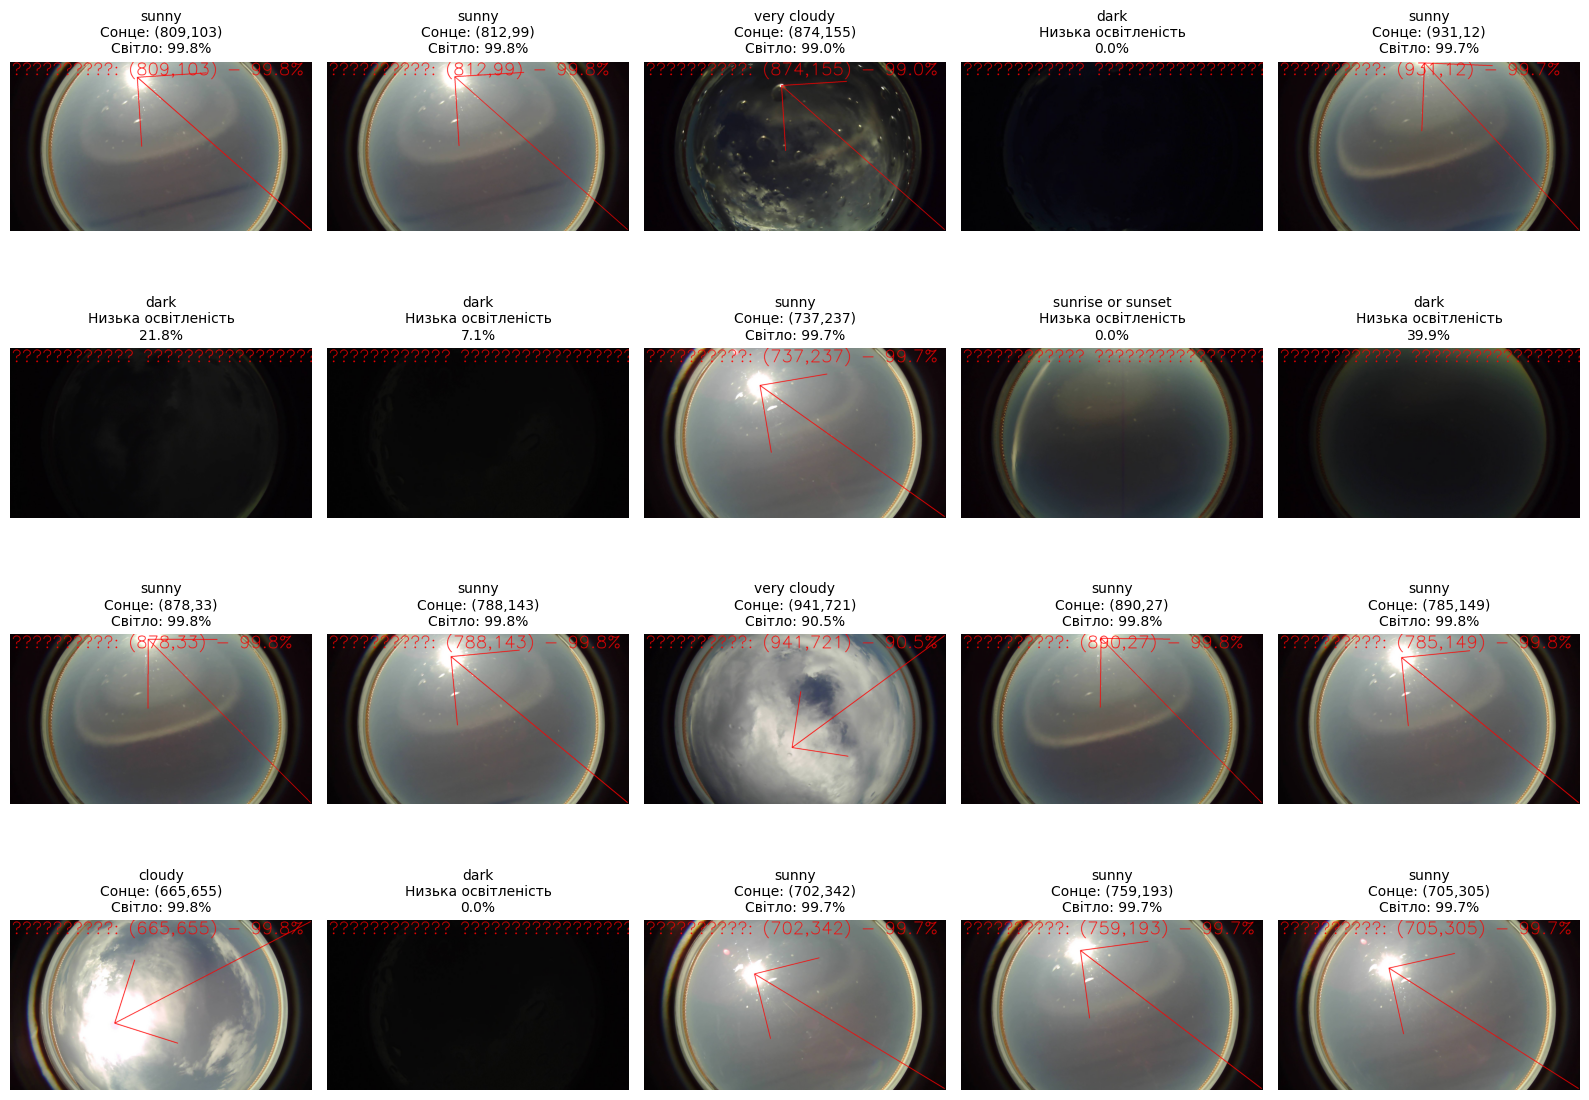

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import logging

# –ù–∞–ª–∞—à—Ç—É–≤–∞–Ω–Ω—è –ª–æ–≥—É–≤–∞–Ω–Ω—è –¥–ª—è –∑–∞–ø–∏—Å—É –ø–æ–º–∏–ª–æ–∫
logging.basicConfig(filename='error_log.txt', level=logging.WARNING)

# –ó–∞–≤–∞–Ω—Ç–∞–∂–µ–Ω–Ω—è –¥–∞–Ω–∏—Ö —ñ–∑ —Ñ–∞–π–ª—É
df = pd.read_csv("sky_features.csv")

# –û–∑–Ω–∞–∫–∏ –¥–ª—è –º–æ–∂–ª–∏–≤–æ–≥–æ –∞–Ω–∞–ª—ñ–∑—É
features = ['cloud_coverage', 'white_pixel_ratio', 'sun_luminance_mean',
            'sun_luminance_max', 'hour', 'minute']

# –ü—ñ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–∏—Ö (–∑–∞–ª–∏—à–µ–Ω–æ –¥–ª—è –º–æ–∂–ª–∏–≤–æ–≥–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–∞–Ω–Ω—è)
X = df[features]
y = df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# –§—É–Ω–∫—Ü—ñ—è –¥–ª—è –≤–∏–∑–Ω–∞—á–µ–Ω–Ω—è –ø–æ–ª–æ–∂–µ–Ω–Ω—è —Å–æ–Ω—Ü—è —Ç–∞ –≤—ñ–¥—Å–æ—Ç–∫–∞ –æ—Å–≤—ñ—Ç–ª–µ–Ω–æ—Å—Ç—ñ
def detect_sun_and_light_percent(img):
    """
    –í–∏–∑–Ω–∞—á–∞—î –ø–æ–ª–æ–∂–µ–Ω–Ω—è —Å–æ–Ω—Ü—è —Ç–∞ –≤—ñ–¥—Å–æ—Ç–æ–∫ –æ—Å–≤—ñ—Ç–ª–µ–Ω–æ—Å—Ç—ñ –Ω–∞ –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—ñ.

    –ü–∞—Ä–∞–º–µ—Ç—Ä–∏:
    img (numpy.ndarray): –ó–æ–±—Ä–∞–∂–µ–Ω–Ω—è —É —Ñ–æ—Ä–º–∞—Ç—ñ BGR.

    –ü–æ–≤–µ—Ä—Ç–∞—î:
    tuple: –ö–æ–æ—Ä–¥–∏–Ω–∞—Ç–∏ —Å–æ–Ω—Ü—è (x, y) —Ç–∞ –≤—ñ–¥—Å–æ—Ç–æ–∫ –æ—Å–≤—ñ—Ç–ª–µ–Ω–æ—Å—Ç—ñ.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, int(0.98 * np.max(gray)), 255, cv2.THRESH_BINARY)

    # –ó–Ω–∞—Ö–æ–¥–∏–º–æ –∫–æ–Ω—Ç—É—Ä–∏ —è—Å–∫—Ä–∞–≤–∏—Ö –∑–æ–Ω
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return (0, 0), 0.0  # –Ø–∫—â–æ –∫–æ–Ω—Ç—É—Ä–∏ –Ω–µ –∑–Ω–∞–π–¥–µ–Ω—ñ

    # –í–∏–±–∏—Ä–∞—î–º–æ –Ω–∞–π–±—ñ–ª—å—à—É —è—Å–∫—Ä–∞–≤—É –∑–æ–Ω—É (–º–æ–∂–ª–∏–≤–æ —Å–æ–Ω—Ü–µ)
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)

    if M["m00"] == 0:
        return (0, 0), 0.0  # –Ø–∫—â–æ –º–æ–º–µ–Ω—Ç –¥–æ—Ä—ñ–≤–Ω—é—î –Ω—É–ª—é

    # –¶–µ–Ω—Ç—Ä –º–∞—Å–∏ –∫–æ–Ω—Ç—É—Ä—É ‚Äî –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∏ —Å–æ–Ω—Ü—è
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # –û—Å–≤—ñ—Ç–ª–µ–Ω—ñ—Å—Ç—å ‚Äî —Å–µ—Ä–µ–¥–Ω—î –∑–Ω–∞—á–µ–Ω–Ω—è –≤—Å—ñ—Ö –ø—ñ–∫—Å–µ–ª—ñ–≤ –≤ –∫–æ–Ω—Ç—É—Ä—ñ
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    light_pixels = gray[mask == 255]
    light_level = np.mean(light_pixels) / 255 * 100

    return (cx, cy), light_level

# –§—É–Ω–∫—Ü—ñ—è –¥–ª—è –∞–Ω–Ω–æ—Ç–∞—Ü—ñ—ó –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è
def annotate_image(img, sun_pos, light_pct, label):
    """
    –ê–Ω–Ω–æ—Ç—É—î –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è —Å—Ç—Ä—ñ–ª–∫–æ—é —Ç–∞ —Ç–µ–∫—Å—Ç–æ–º –≤ –∑–∞–ª–µ–∂–Ω–æ—Å—Ç—ñ –≤—ñ–¥ –≤—ñ–¥—Å–æ—Ç–∫–∞ –æ—Å–≤—ñ—Ç–ª–µ–Ω–æ—Å—Ç—ñ.

    –ü–∞—Ä–∞–º–µ—Ç—Ä–∏:
    img (numpy.ndarray): –ó–æ–±—Ä–∞–∂–µ–Ω–Ω—è —É —Ñ–æ—Ä–º–∞—Ç—ñ BGR.
    sun_pos (tuple): –ö–æ–æ—Ä–¥–∏–Ω–∞—Ç–∏ —Å–æ–Ω—Ü—è (x, y).
    light_pct (float): –í—ñ–¥—Å–æ—Ç–æ–∫ –æ—Å–≤—ñ—Ç–ª–µ–Ω–æ—Å—Ç—ñ.
    label (str): –ú—ñ—Ç–∫–∞ –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è.

    –ü–æ–≤–µ—Ä—Ç–∞—î:
    numpy.ndarray: –ê–Ω–Ω–æ—Ç–æ–≤–∞–Ω–µ –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è.
    str: –¢–µ–∫—Å—Ç –¥–ª—è –∑–∞–≥–æ–ª–æ–≤–∫–∞.
    """
    h, w = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = min(h, w) / 300  # –ê–¥–∞–ø—Ç–∏–≤–Ω–∏–π —Ä–æ–∑–º—ñ—Ä —à—Ä–∏—Ñ—Ç—É
    thickness = max(1, int(font_scale))  # –¢–æ–≤—â–∏–Ω–∞ —Ç–µ–∫—Å—Ç—É

    if light_pct >= 70:
        x, y = sun_pos
        # –î–∏–Ω–∞–º—ñ—á–Ω–∞ –ø–æ—á–∞—Ç–∫–æ–≤–∞ —Ç–æ—á–∫–∞ —Å—Ç—Ä—ñ–ª–∫–∏
        start_x = 10 if x > w // 2 else w - 10
        start_y = 10 if y > h // 2 else h - 10
        cv2.arrowedLine(img, (start_x, start_y), (x, y), (0, 0, 255), 3, tipLength=0.3)

        text = f"–°–æ–Ω—Ü–µ: ({x},{y}) - {light_pct:.1f}%"
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
        x_text = 10
        y_text = th + 10  # –¢–µ–∫—Å—Ç —É –≤–µ—Ä—Ö–Ω—ñ–π —á–∞—Å—Ç–∏–Ω—ñ

        cv2.putText(
            img,
            text,
            (x_text, y_text),
            font,
            font_scale,
            (0, 0, 255),
            thickness
        )

        title_text = f"{label}\n–°–æ–Ω—Ü–µ: ({x},{y})\n–°–≤—ñ—Ç–ª–æ: {light_pct:.1f}%"
    else:
        text = f"–ù–∏–∑—å–∫–∞ –æ—Å–≤—ñ—Ç–ª–µ–Ω—ñ—Å—Ç—å: {light_pct:.1f}%"
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
        x_text = 10
        y_text = th + 10  # –¢–µ–∫—Å—Ç —É –≤–µ—Ä—Ö–Ω—ñ–π —á–∞—Å—Ç–∏–Ω—ñ

        cv2.putText(
            img,
            text,
            (x_text, y_text),
            font,
            font_scale,
            (0, 0, 255),
            thickness
        )

        title_text = f"{label}\n–ù–∏–∑—å–∫–∞ –æ—Å–≤—ñ—Ç–ª–µ–Ω—ñ—Å—Ç—å\n{light_pct:.1f}%"

    return img, title_text

# –í–∏–±—ñ—Ä 20 –≤–∏–ø–∞–¥–∫–æ–≤–∏—Ö –∑–æ–±—Ä–∞–∂–µ–Ω—å
sample = df.sample(20, random_state=42)

plt.figure(figsize=(16, 12))

for i, row in enumerate(sample.itertuples()):
    path = os.path.join("images", row.label, os.path.basename(row.filename))
    img = cv2.imread(path)

    if img is None:
        logging.warning(f"–ù–µ –≤–¥–∞–ª–æ—Å—è –∑–∞–≤–∞–Ω—Ç–∞–∂–∏—Ç–∏ –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è: {path}")
        continue

    sun_pos, light_pct = detect_sun_and_light_percent(img)
    img_annotated, title_text = annotate_image(img, sun_pos, light_pct, row.label)

    img_rgb = cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(title_text, fontsize=10)

plt.tight_layout()
plt.show()